# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
import torch.nn
%load_ext autoreload
%autoreload 2

from sys import platform
from utilities import *
from IPython.display import display

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier
from models.bertOne import BertOne

from DrTorch.utilities import DataLoaderFromPipelineStrategy


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.1+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Wed Feb 28 14:54:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P4              10W /  80W |     53MiB /  8188MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
##### PATHS AND DIRECTORY

DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

# Directory paths for model and result storage
BERT_DIRECTORY = "local-bert"
RESULT_DIRECTORY = 'results'  # Directory to store the results
GRID_DIRECTORY = 'grid'  # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'  # Directory to store model weights

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 

# File paths for grid search results
FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'freezed_bertone_grid_search_results.pkl')
UNFREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'unfreezed_bertwo_grid_search_results.pkl')

# File paths for model weights
FREEZED_BERTONE_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'freezed_bertone_wights.pth')
UNFREEZED_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'unfreezed_bertone_wights.pth')

# BERT HIDDEN DIMENSION
BERT_HIDDEN_DIM = 768 # bert hidden dimension 
PATIENCE = 3 #Patience of the early stoppers


##### FLAGS FOR MODEL TRAINING AND EVALUATION

# Flags for running additional classifiers
RUN_RANDOM_CLF = True
RUN_MAJORITY_CLF = True


# Flags for fitting different BERT models
FIT_FREEZED_BERTONE = True
FIT_UNFREEZED_BERTONE = True


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Plotting Word Cloud 

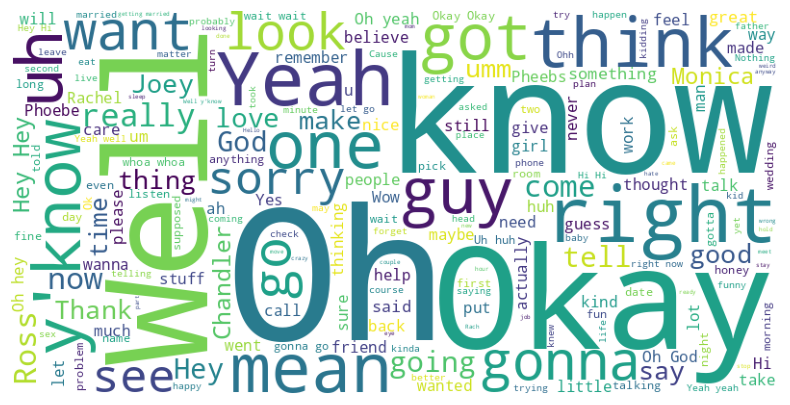

In [7]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [8]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
TRIGGERS = np.unique([item for sublist in df["triggers"] for item in sublist])

EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX


{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

### Taking a look to same utterance example

In [9]:
display_dialogue(dataframe=df, utterance_id='utterance_6')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')

### Removing NaN Values

Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Analyzing the dataset

In [10]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


In [11]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 


### Splitting the dataset 

In [12]:
train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df.head())

print("\nValidation Set: ")
display(val_df.head())

print("\nTest Set: ")
display(test_df.head())


Training Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_1272,"[Ross, Chandler, Monica, Ross, Monica, Monica,...","[surprise, joy, neutral, neutral, surprise, sa...","[....and 12, 22, 18, four... What?, I spelled...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3195,"[Monica, Chandler, Chandler, Chandler, Rachel,...","[surprise, sadness, anger, neutral, neutral, a...",[I can't believe this. Do you think that your ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
utterance_1886,"[Monica, Monica, Monica, Monica, Monica, Rache...","[neutral, joy, neutral, neutral, anger, neutra...","[Windows are clean, candels are lit., Uh, belt...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
utterance_1636,"[Phoebe, Rachel, Phoebe, Rachel, Dr. Green, Ra...","[neutral, surprise, sadness, fear, neutral, su...",[I'm sorry I won't be able to make it to your ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
utterance_3873,"[Rachel, Monica, Rachel, Monica, Phoebe, Monic...","[sadness, neutral, joy, neutral, neutral, neut...","[I'm so sorry, you guys. I didn't mean to brin...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Validation Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_1719,"[Tag, Rachel, Tag, Rachel, Ross, Rachel, Chand...","[neutral, surprise, neutral, surprise, neutral...","[This one's from me., Ahh!, It wasn't on your ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_341,"[Rachel, Joey, Rachel]","[joy, surprise, neutral]",[Monica? You gonna be very proud of me. I just...,"[0.0, 1.0, 1.0]"
utterance_878,"[Joey, The Vendor, Joey, Chandler, Joey, Chand...","[joy, neutral, neutral, neutral, neutral, ange...","[Hey!, So, what are you guys in the market for...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3079,"[Phoebe, Joey, Phoebe, Joey, Phoebe, Joey]","[joy, neutral, neutral, surprise, sadness, joy]","[Oh hey! How was your audition?, I'm sorry, do...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
utterance_348,"[Rachel, Joey, Rachel, Joey, Rachel, Monica, R...","[joy, surprise, neutral, neutral, joy, joy, su...",[Monica? You gonna be very proud of me. I just...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Test Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_3708,"[Monica, Rachel, Chip, Rachel, Chip, Rachel, C...","[fear, neutral, joy, joy, neutral, neutral, su...",[Not yet! Not yet! Not yet! Not yet! Not yet! ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_3022,"[Joey, Joey, Joey, Joey, Joey, Joey, Joey, Joe...","[joy, joy, joy, joy, joy, joy, joy, neutral, n...","[Yes!, I win again!, Ha-ha!, That's like 500 b...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
utterance_2472,"[Ross, Joey, Ross, Rachel, Rachel, Paolo, Ross]","[surprise, surprise, surprise, neutral, neutra...","[Well, not playing raquetball!, He forgot to l...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
utterance_1671,"[Julie, Rachel, Rachel, Rachel, Rachel, Julie,...","[neutral, neutral, neutral, neutral, neutral, ...","[So., So., I just thought the two of us should...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1451,"[Monica, Joey, Joey, Monica, Joey, Monica]","[joy, neutral, neutral, surprise, disgust, anger]","[Hey! Where ya headin' in those pants? 1982?,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


### Visualizing the classes distribution over the datasets

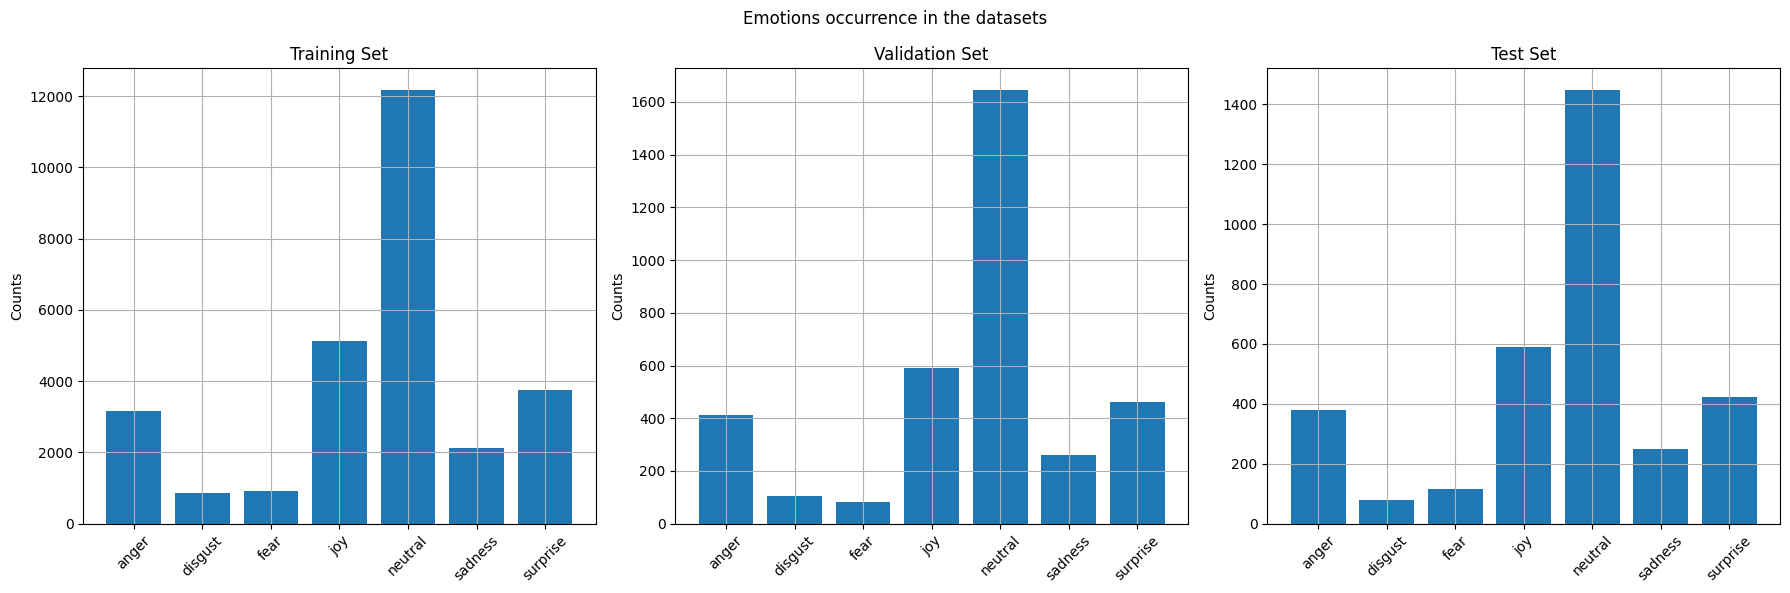

In [13]:
plot_emotion_distribution(train_df, val_df, test_df)


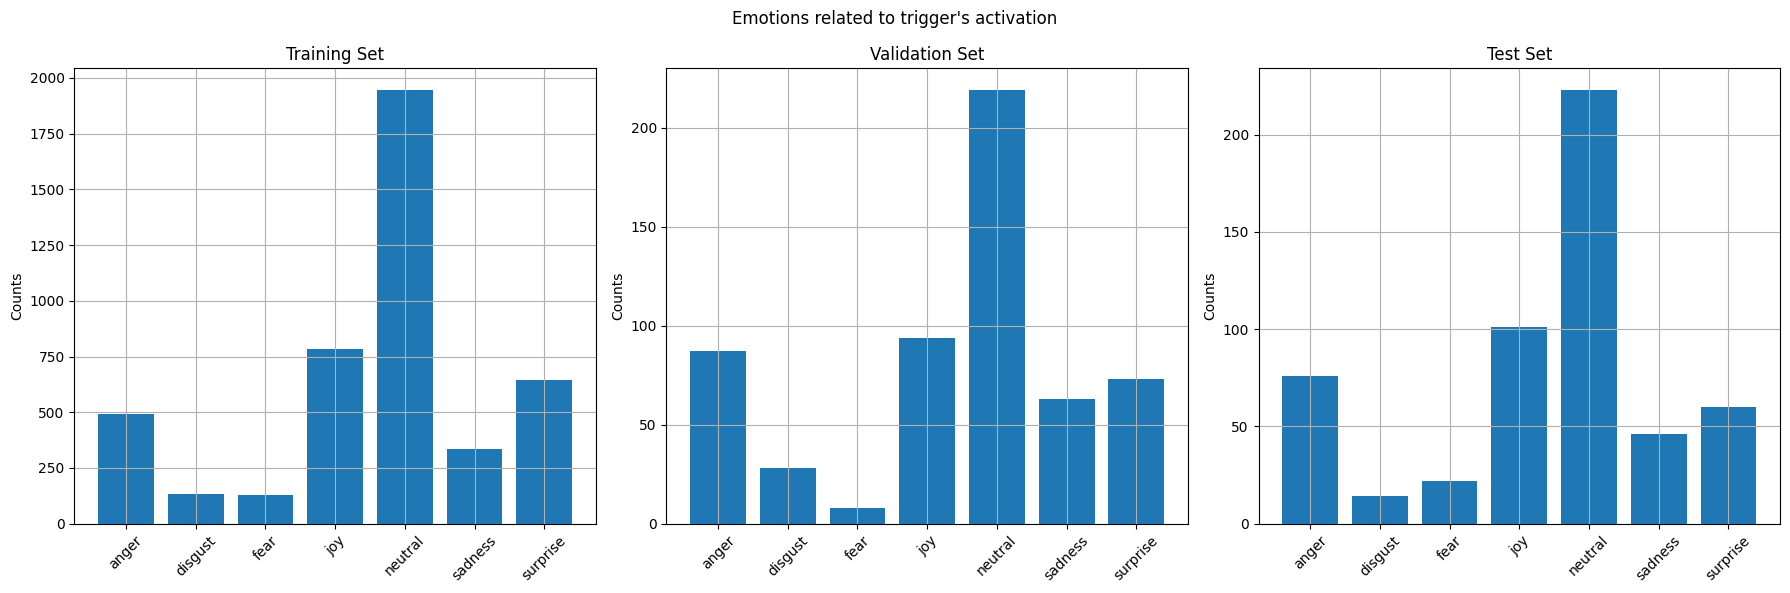

In [14]:
# How many times each emotion activates a trigger
plot_triggers_per_emotion(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [15]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
emotion_weights = np.append(emotion_weights, 0)

trigger_weights = create_classes_weights(df['triggers'].sum())
trigger_weights = np.append(trigger_weights, 0)

padded_emotions = list(EMOTIONS) + ['z_emotion']    
padded_triggers = list(TRIGGERS) + [2]

print('Emotion weights')
display(pd.DataFrame({'Emotion': padded_emotions, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': padded_triggers, 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426
7,z_emotion,0.000000


Trigger weights


,Trigger,Weight
0,0.0,0.594761
1,1.0,3.138206
2,2.0,0.000000


## Random Classifier

In [16]:
# todo metric computation
if RUN_RANDOM_CLF:

    emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
    random_classifier = RandomClassifier(emotions)
    
    pred_emotions, pred_triggers = random_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df, utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,fear,Not yet! Not yet! Not yet! Not yet! Not yet! N...,0.0,neutral,0
1,Rachel,neutral,"Hello, Chip.",0.0,sadness,0
2,Chip,joy,"Hey, Rach! How ya doin'?",0.0,disgust,1
3,Rachel,joy,I'm great! I'm great. I've got a great job at,0.0,fear,0
4,Chip,neutral,"So ah, Monica ready yet?",0.0,surprise,0
5,Rachel,neutral,"She'll be out in a second. So, Chip, how's umm...",1.0,surprise,1
6,Chip,surprise,Amy Welch? Wow! I haven't seen her since... So...,0.0,sadness,1


## Majority Classifier

In [17]:
# todo metrics computation
if RUN_MAJORITY_CLF:
    majority_classifier = MajorityClassifier()
    
    majority_classifier.fit(train_df)
    pred_emotions, pred_triggers = majority_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,fear,Not yet! Not yet! Not yet! Not yet! Not yet! N...,0.0,neutral,0.0
1,Rachel,neutral,"Hello, Chip.",0.0,neutral,0.0
2,Chip,joy,"Hey, Rach! How ya doin'?",0.0,neutral,0.0
3,Rachel,joy,I'm great! I'm great. I've got a great job at,0.0,neutral,0.0
4,Chip,neutral,"So ah, Monica ready yet?",0.0,neutral,0.0
5,Rachel,neutral,"She'll be out in a second. So, Chip, how's umm...",1.0,neutral,0.0
6,Chip,surprise,Amy Welch? Wow! I haven't seen her since... So...,0.0,neutral,0.0


## Bert Models

In [18]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


#### Creating Data Loader

In [19]:
from functools import partial

max_tokenized_length = find_max_encoded_utterance(bert_tokenizer, df['utterances'])
my_tokenization_f = partial(tokenize_data, max_tokenized_length=max_tokenized_length, tokenizer=bert_tokenizer)


dataLoaderBuilder = DataLoaderFromPipelineStrategy()


train_dataloader = dataLoaderBuilder.create(data=train_df["utterances"].copy(), 
                                            labels=train_df[["emotions", "triggers"]].copy(), 
                                            shuffle=True,
                                            data_preprocess_f=my_tokenization_f, 
                                            labels_preprocess_f=preprocess_labels,
                                            batch_size=32,
                                            device=device)

val_dataloader = dataLoaderBuilder.create(data=val_df["utterances"].copy(), 
                                          labels=val_df[["emotions", "triggers"]].copy(), 
                                          shuffle=False,
                                          data_preprocess_f=my_tokenization_f, 
                                          labels_preprocess_f=preprocess_labels,
                                          batch_size=32,
                                          device=device)

test_dataloader = dataLoaderBuilder.create(data=test_df["utterances"].copy(), 
                                           labels=test_df[["emotions", "triggers"]].copy(), 
                                           shuffle=False,
                                           data_preprocess_f=my_tokenization_f, 
                                           labels_preprocess_f=preprocess_labels,
                                           batch_size=32,
                                           device=device)
    


n_token_per_utterance = next(iter(train_dataloader))[0]['input_ids'].shape[-1] 



### Fitting Freezed BertOne

In [ ]:
from DrTorch.metrics import MultyHeadMetric, F1_Score
from DrTorch.callbacks import EarlyStopper
from DrTorch.wrappers import OptimizerWrapper,Criterion, MultyHeadCriterion

torch.manual_seed(42)
np.random.seed(42)

freezed_bert_1 = BertOne(bert_model=bert_model,
                         n_emotions=len(padded_emotions),
                         n_triggers=len(padded_triggers),
                         cls_input_size=n_token_per_utterance*BERT_HIDDEN_DIM,
                         freeze_bert_weights=True).to(device)


if FIT_FREEZED_BERTONE:
        
        #Losses definitions and combination
        emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                      loss_function=torch.nn.CrossEntropyLoss(reduction='none'))  
        
        trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                      loss_function=torch.nn.CrossEntropyLoss(reduction='none'))
        
        multi_head_criterion = MultyHeadCriterion(name='aggregate_CE_loss',
                                                  loss_functions={'emotions': emotion_criterion, 
                                                                  'triggers': trigger_criterion},
                                                  loss_weights=[1, 1],
                                                  reduction_function=torch.mean)
        
        #Metrics definitions and combination
        emotion_metric = F1_Score(name='emotion_F1',
                                  mode='macro',
                                  num_classes=len(padded_emotions),
                                  classes_to_exclude=[8])     
        
        trigger_metric = F1_Score(name='triggers_F1',
                                  mode='macro',
                                  num_classes=len(padded_triggers),
                                  classes_to_exclude=[2])     

        
        multi_head_metric = MultyHeadMetric(name='aggregate_avg_F1',
                                            metrics_functions={'emotions': emotion_metric,
                                                               'triggers': trigger_metric},
                                            metric_weights=[1, 1],
                                            aggregate_metrics_function=torch.mean)
        
        
        optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                     identifier=f'lr={1e-5}', 
                                     optimizer_partial_params={'lr': 1e-5})  

        early_stopper = EarlyStopper(monitor='aggregate_CE_loss', 
                                     patience=PATIENCE, 
                                     delta=0, 
                                     mode='min',
                                     restore_weights=True)

        freezed_bert_1_history = freezed_bert_1.fit(train_loader=train_dataloader,
                                                    val_loader=val_dataloader,
                                                    criterion=multi_head_criterion,
                                                    metrics=[multi_head_metric],
                                                    optimizer=optimizer,
                                                    early_stopper=early_stopper,
                                                    num_epochs=2)





 Epoch: 1/2 Iterations: 8/100 - aggregate_CE_loss: 12.28468540717255 - emotion_F1: 0.18727219918346016 - triggers_F1: 0.32980960500142087 - aggregate_avg_F1: 0.258540902092440585

In [ ]:
"""
from DrTorch.utilities import plot_history

if FIT_FREEZED_BERTONE:
    plot_history(freezed_bert_1_history, patience=PATIENCE)

else:
    print("To show the bert w/C training history you should set the flag FIT_BERTONE=True ")
""";


In [ ]:

####da qua partono el prove che sto facendo per visualizzare la rete 

In [ ]:

from IPython.display import IFrame

import torch
import torchvision.models as models
import netron

# Definiamo un modello di esempio, ad esempio ResNet18
model = models.resnet18()

# Salviamo il modello in formato ONNX
torch.onnx.export(model, torch.randn(1, 3, 224, 224), "resnet18.onnx", export_params=True)

netron.start("resnet18.onnx", browse=False)
netron_url = "http://localhost:8080/"

# Incorporiamo la visualizzazione del modello utilizzando un IFrame
IFrame(netron_url, width=800, height=600)

In [ ]:
import torch
import torchvision.models as models
import netron
from IPython.display import IFrame

class ModelWithDict(torch.nn.Module):
    def __init__(self):
        super(ModelWithDict, self).__init__()

    def forward(self, input_tensor1, input_tensor2):
        output_dict = {'output1': input_tensor1 * 2, 'output2': input_tensor2 + 1}
        return output_dict

model = ModelWithDict()

# Salviamo il modello in formato ONNX
input_example1 = torch.randn(1, 3, 224, 224)
input_example2 = torch.randn(1, 3, 224, 224)

torch.onnx.export(model, (input_example1, input_example2), "model_with_dict.onnx", export_params=True)

# Avviamo il server Netron senza aprire automaticamente il browser
netron.start("model_with_dict.onnx", browse=False)

# Otteniamo l'URL per la visualizzazione del modello
netron_url = "http://localhost:8080/"

# Incorporiamo la visualizzazione del modello utilizzando un IFrame
IFrame(netron_url, width=800, height=600)


In [ ]:
import torch
import torch.nn as nn
import torch.onnx
import netron
from transformers import BertModel

# Definizione del modello BERT come parte del tuo modello
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier1 = torch.nn.Linear(768, 2)
        self.classifier2 = torch.nn.Linear(768, 3)

    def forward(self, inputs):
        input_ids = inputs.get('input_ids')
        attention_mask = inputs.get('attention_mask')
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        return logits1, logits2

# Creazione di un'istanza del modello
model = MyModel()

# Definizione di un input di esempio (dizionario)
input_dict = {'input_ids': torch.randint(1, 100, (2, 4)),
              'attention_mask': torch.ones(2, 4)}

# Conversione del modello in formato ONNX
torch.onnx.export(model, input_dict, "bert_model.onnx", input_names=['inputs'], output_names=['logits1', 'logits2'])

# Visualizzazione del grafico del modello con Netron
netron.start("bert_model.onnx")


In [ ]:
next(iter(train_dataloader))[0]

In [ ]:
from transformers.convert_graph_to_onnx import convert

freezed_bert_1 = BertOne(bert_model=bert_model,
                         n_emotions=len(padded_emotions),
                         n_triggers=len(padded_triggers),
                         cls_input_size=n_token_per_utterance*BERT_HIDDEN_DIM,
                         freeze_bert_weights=True).to(device)



input_example = {'input_ids': torch.zeros((1, 3, 6), dtype=torch.long),
                 'attention_mask': torch.ones((1, 3, 6), dtype=torch.long),
                 'token_type_ids': torch.zeros((1, 3, 6), dtype=torch.long)}

# Converti il modello in formato ONNX
onnx_model_path = "my_model.onnx"
convert(model=freezed_bert_1, framework="pt", opset=11, output=onnx_model_path, inputs=next(iter(train_dataloader)))

onnx_model_path = "my_model.onnx"

# Avvia Netron per visualizzare il modello ONNX
netron.start(onnx_model_path)